# Panel Flutter Analysis of a Metallic Plate

In [1]:
# %cd ..
# %cd src
output_dir = '/output'

## Defining the structural model

First we define the plate geometry

In [2]:
import numpy as np

ab = 1. # a/b

a = 300. # mm

b = a/ab

p1 = np.array([0, 0, 0])
p2 = p1 + np.array([a, 0, 0])
p3 = p1 + np.array([a, b, 0])
p4 = p1 + np.array([0, b, 0])

thickness = 1.5 # mm

Defining the number of elements in chordwise and spanwise

In [3]:
nchord, nspan = 20, 20

Defining the material properties

- E = 71.7 GPa
- G = 26.9 GPa
- $\nu$ = 0.33
- $\rho$ = 2.81 g/cm³
- $\alpha$ = 21e-6 mm/mmC°


In [4]:
from nastran.structures.material import IsotropicMaterial

al = IsotropicMaterial(1, 71700., .33, 26900., 2.81e-9, alpha=21e-6)

ModuleNotFoundError: No module named 'nastran'

Generating the plate

In [ ]:
from nastran.structures.panel import IsotropicPlate

plate = IsotropicPlate.create_plate(p1, p2, p3, p4, nspan, nchord, 1, thickness, al)

## Generating the Flutter Analysis

Configurations for the aeroelastic sequence

In [44]:
config = {
    'vref': 1000.,                      # used to calculate the non-dimensional dynamic pressure must be the same in control case (mm/s in the case)
    'ref_rho': 1.225e-12,               # air density reference (ton/mm^3 in the case)
    'ref_chord': 300.,                  # reference chord (mm in the case)
    'n_modes': 15,                      # number searched modes in modal analysis
    'frequency_limits': 
        [.0, 1000.],                    # the range of frequency (Hz) in modal analysis
    'method': 'PK',                     # the method for solving flutter (it will determine the next parameters
    'densities_ratio': [.5],            # rho/rho_ref -> 1/2 simulates the "one side flow" of the panel (? reference ?)
    'machs': [3.0],                     # Mach numbers
    'alphas': [0., 0., 0., 0.],         # AoA (°) -> 0 is more conservative (? reference ?)
    'reduced_frequencies': 
        [.001, .1, .2, .4],             # reduced frequencies (k) (check influence)
    'velocities':                       # velocities (mm/s in the case)
        np.linspace(822, 1066, 50)*1000,
}

In [45]:
params =  {
    'VREF': 1000.0,
    'COUPMASS': 1,
    'LMODES': 15,
    'WTMASS': 1.,
    'GRDPNT': 1,
    'OPPHIPA': 1,
    # 'POST': [-1]
}

Generating the Panel Flutter analysis

In [46]:
from nastran.aero.analysis.panel_flutter import PanelFlutterPistonAnalysisModel

analysis = PanelFlutterPistonAnalysisModel(plate.bdf, params=params)
analysis.set_global_case_from_dict(config)

Defining Boundary Conditions

In [42]:
from nastran.structures.bc import create_spcs_and_subcases, generate_bc_case
from nastran.aero.analysis.panel_flutter import PanelFlutterSubcase

spc_cases = {
    1: generate_bc_case('SSSS') # Fully simply-supported
}

nodes = plate.limit_nodes()
nodes[2] = nodes[2][1:-1]
nodes[3] = nodes[3][1:-1]

create_spcs_and_subcases(analysis, spc_cases, nodes, PanelFlutterSubcase)

Adding the Aerodynamic model

In [47]:
spanel_p = SuperAeroPanel5(1, p1, p2, p3, p4, nchord, nspan, theory='VANDYKE')
analysis.add_superpanel(spanel_p)

Aerodynamic Flutter solution created!


Write down the cards

In [ ]:
analysis.write_cards()

Write the model to file

In [48]:
model_filename = 'metallic'
analysis.model.write_bdf(output_dir+model_filename+'.bdf', enddata=True)

subcase=1 already exists...skipping
subcase=1 already exists...skipping
subcase=1 already exists...skipping
subcase=1 already exists...skipping
subcase=1 already exists...skipping
subcase=1 already exists...skipping
subcase=1 already exists...skipping


## Post-processing

In [49]:
from nastran.post.f06 import read_f06
from nastran.post.flutter import get_critical_roots, join_flutter_pages, flutter_pages_to_df
from nastran.post.plots import plot_vf_vg

#%%
res = read_f06(output_dir+model_filename+'.f06')
res

F06 Results with 70 pages.

In [50]:
pages = join_flutter_pages(res.flutter)
pages

[FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=1,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=2,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=3,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=4,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=5,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=6,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=7,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=8,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=9,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=10,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=11,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=12,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=13,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=14,
 FLUTTER F06 PAGE	SUBCASE=1	LABEL=TEMP LOAD 0.000010	MODE=15]

In [51]:
df = flutter_pages_to_df(pages)
df

KFREQ  1./KFREQ   VELOCITY   DAMPING  \
SUBCASE MACH NUMBER POINT INDEX                                          
1       3.0         1     0      0.1371  7.291685   822.0000 -0.112849   
                          1      0.1373  7.281624   826.9796 -0.112693   
                          2      0.1375  7.270734   831.9592 -0.112525   
                          3      0.1378  7.259012   836.9388 -0.112343   
                          4      0.1380  7.246456   841.9184 -0.112149   
...                                 ...       ...        ...       ...   
                    15    45     1.2382  0.807639  1046.0820 -0.013390   
                          46     1.2323  0.811496  1051.0610 -0.013454   
                          47     1.2265  0.815354  1056.0410 -0.013518   
                          48     1.2207  0.819211  1061.0200 -0.013582   
                          49     1.2150  0.823070  1066.0000 -0.013646   

                                  FREQUENCY  REALEIGVAL  IMAGEIGVAL  
SUBCASE MACH NUMBER POINT INDEX                                      
1       3.0         1     0       119.61147  -42.405253   751.54101  
                          1       120.50233  -42.662160   757.13848  
                          2       121.40950  -42.919069   762.83837  
                          3       122.33340  -43.175979   768.64339  
                          4       123.27449  -43.432891   774.55647  
...                                     ...         ...         ...  
                    15    45     1374.28600  -57.810738  8634.89370  
                          46     1374.26460  -58.086014  8634.75910  
                          47     1374.24290  -58.361347  8634.62250  
                          48     1374.22080  -58.636629  8634.48410  
                          49     1374.19850  -58.911968  8634.34360  

[750 rows x 7 columns]

In [52]:
get_critical_roots(df)

,,,KFREQ,1./KFREQ,VELOCITY,DAMPING,FREQUENCY,REALEIGVAL,IMAGEIGVAL
SUBCASE,MACH NUMBER,POINT,,,,,,,
1,3.0,2,0.16595,6.025719,998.77535,0.0,175.868145,-8.5773,1105.0121


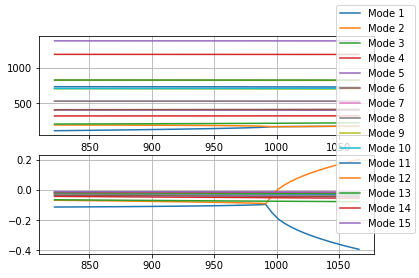

In [53]:
p = plot_vf_vg(df)

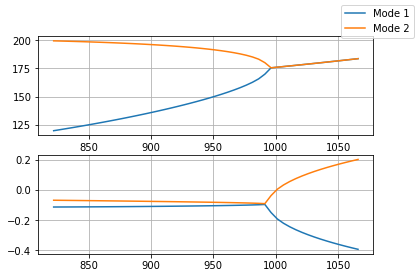

In [54]:
p = plot_vf_vg(df, modes=(1,2))